In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, r2_score,accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import HistGradientBoostingRegressor
import random
import re

In [67]:
import warnings
warnings.filterwarnings('ignore')

## CROP DATA CLEANING

### 1. Data Loading and Raw Data Cleaning

In [68]:
df = pd.read_csv(r"E:\UMBC Course\SEMESTER_4\mlproject-main\mlproject-main\notebook\data\Crops_output_2.csv", low_memory=False)

df.dropna(axis=1, how='all', inplace=True)
df.drop(columns=['Program', 'watershed_code', 'Domain Category', 'Week Ending', 'State ANSI'], inplace=True, errors='ignore')

In [69]:
df.head()

,Year,Period,Geo Level,State,Commodity,Data Item,Domain,Value
0,2001,April,STATE,ARIZONA,HAY,"HAY - PRICE RECEIVED, MEASURED IN $ / TON",TOTAL,100
1,2001,April,STATE,ARIZONA,HAY,"HAY, (EXCL ALFALFA) - PRICE RECEIVED, MEASURED...",TOTAL,90
2,2001,April,STATE,ARIZONA,HAY,"HAY, ALFALFA - PRICE RECEIVED, MEASURED IN $ /...",TOTAL,100
3,2001,April,STATE,ARKANSAS,COTTON,"COTTON, UPLAND - PRICE RECEIVED, MEASURED IN $...",TOTAL,0.515
4,2001,April,STATE,ARKANSAS,SORGHUM,"SORGHUM, GRAIN - PRICE RECEIVED, MEASURED IN $...",TOTAL,3.66


In [70]:
exclude_commodities = [
    'PASTURELAND', 'GRAIN STORAGE CAPACITY', 'FIELD CROP TOTALS', 'HAY & HAYLAGE',
    'MAPLE SYRUP', 'GRAIN', 'LEGUMES', 'HEMP'
]

In [71]:
df = df[~df['Commodity'].isin(exclude_commodities)]
df = df[~df["Data Item"].str.contains(r"(COTTON - NUMBER OF ACTIVE GINS|NUMBER OF SAMPLES|ACRES REMAINING TO BE PLANTED|ACRES (?:PLANTED|HARVESTED))", case=False, regex=True, na=False)]

### 2. Extracting Metrics & Standardizing Value Formats

In [72]:
df[["Item", "Metric", "Measurement_Unit"]] = df["Data Item"].str.extract(r"(.+?) - (.+?), (.+)?", expand=True)
df['Unit_Extracted'] = df['Measurement_Unit'].str.extract(r"MEASURED IN \$ / (\w+)", expand=True)

In [73]:
df['Value'] = df['Value'].astype(str).str.replace(',', '', regex=True)
df['Value'] = df['Value'].replace([r"\(.*?\)", r"[A-Za-z]"], np.nan, regex=True)
df['Value'] = pd.to_numeric(df['Value'])

In [74]:
conversion_factors = {
    "TON": 1, "LB": 2000, "CWT": 20,
    "BU": {
        "corn": 35.7, "wheat": 33.3, "soybeans": 33.3, "oats": 62.5,
        "barley": 41.7, "sorghum": 35.7, "rice": 44.4, "peanuts": 25.0,
        "sunflower": 42.0, "flaxseed": 52.1, "rye": 36.0, "millet": 50.0,
        "lentils": 60.0, "peas": 60.0, "canola": 50.0, "chickpeas": 60.0,
        "mustard": 50.0, "safflower": 50.0, "camelina": 50.0, "rapeseed": 50.0
    }
}

In [75]:
def convert_to_ton(value, unit, commodity):
    if pd.isna(value) or pd.isna(unit): return value
    unit = unit.strip().upper()
    if unit == "TON": return value
    elif unit == "LB": return value * conversion_factors["LB"]
    elif unit == "CWT": return value * conversion_factors["CWT"]
    elif unit == "BU":
        factor = conversion_factors["BU"].get(commodity.lower().strip(), 35.7)
        return value * factor
    return value

In [76]:
df['PRICE_IN_TON'] = df.apply(
    lambda row: convert_to_ton(row['Value'], row['Unit_Extracted'], row['Commodity'])
    if row['Metric'] == 'PRICE RECEIVED' else row['Value'], axis=1
)

In [77]:
df['Pivot_Value'] = df.apply(lambda row: row['PRICE_IN_TON'] if row['Metric'] == 'PRICE RECEIVED' else row['Value'], axis=1)

### 3. Pivoting the DataFrame for Metric-wise Columns

In [78]:
pivot_df = df.pivot_table(
    index=["Year", "Period", "Geo Level", "State", "Commodity"],
    columns="Metric",
    values="Pivot_Value",
    aggfunc="first"
).reset_index()

pivot_df.columns.name = None
pivot_df.columns = [str(col) for col in pivot_df.columns]

In [79]:
pivot_df.head()

,Year,Period,Geo Level,State,Commodity,ACTIVITY,AREA FLOODED,AREA PLANTED,BOLL COUNT,CONDITION,...,PRODUCTION,PROGRESS,RATIO,ROW WIDTH,SALES,SEED FOR PLANTING,START DATE,STOCKS,SUCROSE,YIELD
0,2001,April,STATE,ALABAMA,COTTON,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,April,STATE,ALABAMA,SORGHUM,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
2,2001,April,STATE,ALABAMA,SOYBEANS,NaN,NaN,NaN,NaN,NaN,...,21735000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001,April,STATE,ALASKA,HAY,NaN,NaN,NaN,NaN,NaN,...,30000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001,April,STATE,ARIZONA,COTTON,NaN,NaN,NaN,NaN,NaN,...,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
selected_columns = [
    'Year', 'Period', 'Geo Level', 'State', 'Commodity',
    'CONDITION', 'PROGRESS', 'PRICE RECEIVED', 'STOCKS',
    'SALES', 'YIELD'
]


df = pivot_df[selected_columns]

In [81]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85551 entries, 0 to 85550
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               85551 non-null  int64  
 1   Period             85551 non-null  object 
 2   Geo Level          85551 non-null  object 
 3   State              85551 non-null  object 
 4   Commodity          85551 non-null  object 
 5   ACTIVITY           122 non-null    float64
 6   AREA FLOODED       1 non-null      float64
 7   AREA PLANTED       3017 non-null   float64
 8   BOLL COUNT         301 non-null    float64
 9   CONDITION          22889 non-null  float64
 10  DAMAGE             106 non-null    float64
 11  DISAPPEARANCE      184 non-null    float64
 12  EAR COUNT          872 non-null    float64
 13  GINNED BALES       1152 non-null   float64
 14  HARVEST LOSS       56 non-null     float64
 15  HEAD COUNT         383 non-null    float64
 16  HEIGHT             222

### 4. Handling Missing Values & Outliers

In [82]:
df_2 = df.dropna()

In [83]:
targets = ['YIELD', 'SALES', 'STOCKS', 'PRICE RECEIVED', 'PROGRESS', 'CONDITION']
cats = ['Year', 'Period', 'Geo Level', 'State', 'Commodity']

train_df = df_2.copy()
full_df = df.copy()


encoders = {}
for col in cats:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], full_df[col]]).astype(str)
    le.fit(combined)
    train_df[col + "_enc"] = le.transform(train_df[col].astype(str))
    full_df[col + "_enc"] = le.transform(full_df[col].astype(str))
    encoders[col] = le

In [84]:
for target in targets:
    features = [col + "_enc" for col in cats] + [t for t in targets if t != target]

    # Train
    valid = train_df[target].notnull()
    model = HistGradientBoostingRegressor(random_state=42)
    model.fit(train_df.loc[valid, features], train_df.loc[valid, target])

    # Impute
    mask = full_df[target].isnull()
    if mask.any():
        X_full = full_df.loc[mask, features].fillna(full_df[features].median())
        full_df.loc[mask, target] = model.predict(X_full)
        print(f"Filled {mask.sum()} missing in {target}")

print("Imputation complete. Original categoricals preserved.")

Filled 49179 missing in YIELD
Filled 48925 missing in SALES
Filled 68065 missing in STOCKS
Filled 43464 missing in PRICE RECEIVED
Filled 53039 missing in PROGRESS
Filled 62662 missing in CONDITION
Imputation complete. Original categoricals preserved.


In [85]:
columns = ['Year_enc', 'Period_enc', 'Geo Level_enc', 'State_enc', 'Commodity_enc']
df = full_df.drop(columns=columns)

In [86]:
df.head()

,Year,Period,Geo Level,State,Commodity,CONDITION,PROGRESS,PRICE RECEIVED,STOCKS,SALES,YIELD
0,2001,April,STATE,ALABAMA,COTTON,15.032714,0.000000,93.690957,6.807783e+07,26.143550,88.897867
1,2001,April,STATE,ALABAMA,SORGHUM,9.049112,77.173252,80.989201,5.455668e+07,15.649264,9.000000
2,2001,April,STATE,ALABAMA,SOYBEANS,11.218004,49.266514,193.929250,2.403578e+07,15.827956,38.747395
3,2001,April,STATE,ALASKA,HAY,8.421371,87.856842,107.126311,-8.116681e+06,15.025129,34.958325
4,2001,April,STATE,ARIZONA,COTTON,15.451718,16.000000,95.319574,7.351657e+07,19.517770,88.897867


In [87]:
df.to_csv(r"E:\UMBC Course\SEMESTER_4\mlproject-main\mlproject-main\notebook\data\crop_data_to_merge.csv")

## Soild Data Cleaning

### 1. Data Loading & Cleaning

In [88]:
soil_path = r"E:\UMBC Course\SEMESTER_4\mlproject-main\mlproject-main\notebook\data\soil_2000_2024.csv"
soil_df = pd.read_csv(soil_path, low_memory=False)

In [89]:
soil_df.head()

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Commodity,Data Item,Domain,...,drainagecl,lep_l,slope_l,slope_r,slope_h,elev_l,elev_r,elev_h,mukey,hydricrating
0,SURVEY,2025,WEEK #01,05-01-2025,STATE,ARIZONA,4,SOIL,"SOIL, SUBSOIL - MOISTURE, MEASURED IN PCT SHORT",TOTAL,...,Well drained,3.0,5.0,7.0,9.0,213.0,335.0,457.0,667263,No
1,SURVEY,2025,WEEK #01,05-01-2025,STATE,ARKANSAS,5,SOIL,"SOIL, SUBSOIL - MOISTURE, MEASURED IN PCT SHORT",TOTAL,...,Well drained,NaN,25.0,33.0,40.0,213.0,335.0,457.0,667263,No
2,SURVEY,2025,WEEK #01,05-01-2025,STATE,CALIFORNIA,6,SOIL,"SOIL, SUBSOIL - MOISTURE, MEASURED IN PCT SHORT",TOTAL,...,Well drained,0.0,9.0,12.0,14.0,213.0,335.0,457.0,667263,No
3,SURVEY,2025,WEEK #01,05-01-2025,STATE,COLORADO,8,SOIL,"SOIL, SUBSOIL - MOISTURE, MEASURED IN PCT SHORT",TOTAL,...,NaN,3.0,25.0,43.0,60.0,NaN,NaN,NaN,667263,No
4,SURVEY,2025,WEEK #01,05-01-2025,STATE,FLORIDA,12,SOIL,"SOIL, SUBSOIL - MOISTURE, MEASURED IN PCT SHORT",TOTAL,...,Well drained,3.0,5.0,7.0,9.0,213.0,335.0,457.0,667263,No


In [90]:
columns_to_keep = [
    'Year', 'Period', 'State', 'Value', 'sandtotal_r', 'silttotal_r', 'claytotal_r',
    'ph1to1h2o_r', 'cec7_r', 'om_r', 'awc_r', 'ksat_r',
    'drainagecl', 'slope_r', 'elev_r'
]
soil_df = soil_df[columns_to_keep]

In [91]:
rename_map = {
    'Value': 'Moisture',
    'sandtotal_r': 'sand_per',
    'silttotal_r': 'slit_per',
    'claytotal_r': 'clay_per',
    'ph1to1h2o_r': 'ph',
    'cec7_r': 'Cation Exchange Capacity',
    'om_r': 'Organic Matter',
    'awc_r': 'Available Water Capacity',
    'ksat_r': 'ksat',
    'drainagecl': 'Drainage Class',
    'slope_r': 'slope',
    'elev_r': 'elev'
}
soil_df.rename(columns=rename_map, inplace=True)

In [92]:
soil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33441 entries, 0 to 33440
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      33441 non-null  int64  
 1   Period                    33441 non-null  object 
 2   State                     33441 non-null  object 
 3   Moisture                  33441 non-null  float64
 4   sand_per                  28061 non-null  float64
 5   slit_per                  28066 non-null  float64
 6   clay_per                  29633 non-null  float64
 7   ph                        29681 non-null  float64
 8   Cation Exchange Capacity  22792 non-null  float64
 9   Organic Matter            24373 non-null  float64
 10  Available Water Capacity  29728 non-null  float64
 11  ksat                      30375 non-null  float64
 12  Drainage Class            32467 non-null  object 
 13  slope                     33292 non-null  float64
 14  elev  

### 2.Handling Missing Values & Outliers

In [93]:
numeric_cols = [
    'sand_per', 'slit_per', 'clay_per', 'ph', 'Cation Exchange Capacity', 'Organic Matter',
    'Available Water Capacity', 'ksat', 'slope', 'elev'
]

log_cols = ['Cation Exchange Capacity', 'Organic Matter', 'ksat']

In [94]:
for col in numeric_cols:
    if soil_df[col].isna().sum() > 0:
        lower, upper = np.percentile(soil_df[col].dropna(), [10, 95])
        rand_fill = np.random.uniform(lower, upper, size=soil_df[col].isna().sum())
        soil_df.loc[soil_df[col].isna(), col] = rand_fill

    # Clip to 1st–99th percentile
    clip_low, clip_high = np.percentile(soil_df[col], [1, 99])
    soil_df[col] = np.clip(soil_df[col], clip_low, clip_high)

    # Log transform
    if col in log_cols:
        soil_df[col] = np.log1p(soil_df[col])

In [95]:
drainage_classes = [
    "Well drained", "Somewhat excessively drained", "Moderately well drained",
    "Somewhat poorly drained", "Excessively drained", "Poorly drained", "Very poorly drained"
]

soil_df['Drainage Class'] = soil_df['Drainage Class'].apply(lambda x: random.choice(drainage_classes) if pd.isna(x) else x)

In [96]:
soil_df.isnull().sum()

Year                        0
Period                      0
State                       0
Moisture                    0
sand_per                    0
slit_per                    0
clay_per                    0
ph                          0
Cation Exchange Capacity    0
Organic Matter              0
Available Water Capacity    0
ksat                        0
Drainage Class              0
slope                       0
elev                        0
dtype: int64

### 3.Handling the Period Values

In [97]:
def convert_to_month(period):
    period = period.upper()

    week_match = re.search(r"WEEK\s*#(\d{1,2})", period)
    if week_match:
        week = int(week_match.group(1))
        # Approximate week to month
        month_by_week = {
            1: "January", 5: "February", 9: "March", 13: "April", 17: "May", 21: "June", 26: "July", 30: "August", 35: "September",
            40: "October", 45: "November", 49: "December"
        }
        for wk in sorted(month_by_week.keys(), reverse=True):
            if week >= wk:
                return month_by_week[wk]

In [98]:
soil_df['Period'] = soil_df['Period'].apply(convert_to_month)

In [99]:
soil_df.head()

,Year,Period,State,Moisture,sand_per,slit_per,clay_per,ph,Cation Exchange Capacity,Organic Matter,Available Water Capacity,ksat,Drainage Class,slope,elev
0,2025,January,ARIZONA,22.0,55.500000,14.500000,30.000000,5.30000,2.866778,0.223144,0.140000,2.319865,Well drained,7.0,335.000000
1,2025,January,ARKANSAS,4.0,30.169275,49.082120,37.914649,6.14508,2.716248,0.368531,0.150394,3.705061,Well drained,33.0,335.000000
2,2025,January,CALIFORNIA,5.0,41.599998,37.400002,21.000000,6.10000,2.525729,1.504077,0.120000,2.319865,Well drained,12.0,335.000000
3,2025,January,COLORADO,24.0,35.400002,33.599998,31.000000,5.60000,3.000794,1.490670,0.130000,2.319865,Excessively drained,43.0,923.110413
4,2025,January,FLORIDA,22.0,35.400002,33.599998,31.000000,5.60000,3.200110,0.378238,0.170000,2.319865,Well drained,7.0,335.000000


In [100]:
soil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33441 entries, 0 to 33440
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      33441 non-null  int64  
 1   Period                    33441 non-null  object 
 2   State                     33441 non-null  object 
 3   Moisture                  33441 non-null  float64
 4   sand_per                  33441 non-null  float64
 5   slit_per                  33441 non-null  float64
 6   clay_per                  33441 non-null  float64
 7   ph                        33441 non-null  float64
 8   Cation Exchange Capacity  33441 non-null  float64
 9   Organic Matter            33441 non-null  float64
 10  Available Water Capacity  33441 non-null  float64
 11  ksat                      33441 non-null  float64
 12  Drainage Class            33441 non-null  object 
 13  slope                     33441 non-null  float64
 14  elev  

In [101]:
soil_df.to_csv(r'E:\UMBC Course\SEMESTER_4\mlproject-main\mlproject-main\notebook\data\soil_to_merge.csv')

## Consolidating Data for Exploratory Analysis and Modeling

In [102]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')      # Convert to numeric
df['State'] = df['State'].astype(str).str.strip().str.title()
df['Period'] = df['Period'].astype(str).str.strip().str.title()

# STEP 2: Clean and convert soil_df
soil_df['Year'] = pd.to_numeric(soil_df['Year'], errors='coerce')
soil_df['State'] = soil_df['State'].astype(str).str.strip().str.title()
soil_df['Period'] = soil_df['Period'].astype(str).str.strip().str.title()

In [103]:
# Grouping the data
soil_grouped = soil_df.groupby(['Year', 'State', 'Period']).mean(numeric_only=True).reset_index()

In [104]:
# Preparing fallback tables
soil_yr_state = soil_grouped.groupby(['Year', 'State']).mean(numeric_only=True).reset_index()
soil_state = soil_grouped.groupby(['State']).mean(numeric_only=True).reset_index()

In [105]:
merged_df = pd.merge(df, soil_grouped, on=['Year', 'State', 'Period'], how='left')

In [106]:
for col in soil_grouped.columns:
    if col not in ['Year', 'State', 'Period']:
        fallback1 = df[['Year', 'State']].merge(soil_yr_state[['Year', 'State', col]], on=['Year', 'State'], how='left')[col]

        fallback2 = df[['State']].merge(soil_state[['State', col]], on='State', how='left')[col]

        merged_df[col] = merged_df[col].fillna(fallback1).fillna(fallback2)

In [107]:
for col in merged_df.select_dtypes(include='number'):
    if merged_df[col].isna().any():
        q25, q75 = merged_df[col].quantile([0.25, 0.75])
        missing = merged_df[col].isna()
        merged_df.loc[missing, col] = np.random.uniform(q25, q75, size=missing.sum())

In [108]:
merged_df.isna().sum()

Year                        0
Period                      0
Geo Level                   0
State                       0
Commodity                   0
CONDITION                   0
PROGRESS                    0
PRICE RECEIVED              0
STOCKS                      0
SALES                       0
YIELD                       0
Moisture                    0
sand_per                    0
slit_per                    0
clay_per                    0
ph                          0
Cation Exchange Capacity    0
Organic Matter              0
Available Water Capacity    0
ksat                        0
slope                       0
elev                        0
dtype: int64

In [109]:
numeric_cols = merged_df.select_dtypes(include='number').columns

merged_df[numeric_cols] = merged_df[numeric_cols].clip(lower=0)

In [110]:
merged_df.describe()

,Year,CONDITION,PROGRESS,PRICE RECEIVED,STOCKS,SALES,YIELD,Moisture,sand_per,slit_per,clay_per,ph,Cation Exchange Capacity,Organic Matter,Available Water Capacity,ksat,slope,elev
count,85551.000000,85551.000000,85551.000000,85551.000000,8.555100e+04,8.555100e+04,85551.000000,85551.000000,85551.000000,85551.000000,85551.000000,85551.000000,85551.000000,85551.000000,85551.000000,85551.000000,85551.000000,85551.000000
mean,2012.652874,11.796172,53.147163,308.835626,6.637413e+07,9.470431e+01,323.674424,22.282524,38.470803,41.266954,22.026174,6.896512,2.777844,0.861578,0.144030,2.377130,7.779372,785.266640
std,6.910944,7.375942,28.494854,1616.296223,1.111617e+08,2.031519e+04,918.851369,12.272301,13.357869,10.195334,6.553481,0.544950,0.267171,0.239427,0.027166,0.621990,5.894484,438.210068
min,2001.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,5.300000,1.400000,2.500000,5.000000,1.252763,0.095310,0.030000,0.190620,1.000000,9.000000
25%,2007.000000,7.226751,33.000000,128.398773,1.944314e+06,3.322475e+00,40.859798,13.200000,30.100000,36.586805,18.783333,6.555376,2.677445,0.744672,0.132227,2.087356,3.500000,474.174656
50%,2013.000000,10.692464,57.000000,175.366236,2.278300e+07,6.019111e+00,56.358782,21.400000,40.789970,39.900000,21.325970,6.979966,2.774115,0.865130,0.140000,2.443418,7.400000,775.793256
75%,2019.000000,15.000000,75.411406,249.900000,9.493688e+07,1.200000e+01,100.000000,31.530556,44.655152,47.673656,25.039286,7.146365,2.917771,0.967468,0.160000,2.583381,8.980356,901.245696
max,2024.000000,100.000000,116.479728,57000.000000,2.404747e+09,5.739000e+06,11300.000000,100.000000,95.400002,72.180002,50.000000,8.500000,3.725693,1.945910,0.230000,4.956812,50.000000,2210.000000


## Generating Soil Labels

In [111]:
def classify_texture(row):
    sand, silt, clay = row['sand_per'], row['slit_per'], row['clay_per']

    if sand >= 70 and clay <= 15:
        return 'Sandy'
    elif clay >= 35:
        return 'Clayey'
    elif silt >= 50 and sand < 30:
        return 'Silty'
    elif 25 <= clay <= 35 and sand >= 30 and silt >= 20:
        return 'Loamy'
    return 'Loamy'

In [112]:
def classify_fertility(row):
    om = row['Organic Matter']
    awc = row['Available Water Capacity']
    cec = row['Cation Exchange Capacity']
    ph = row['ph']
    slope = row['slope']

    if om >= 1.25 and awc >= 0.18 and cec >= 3 and 6 <= ph <= 7.5 and slope < 10:
        return 'High Fertility'
    elif om < 0.5 or awc < 0.1 or ph < 5.8 or slope > 20:
        return 'Low Fertility'
    else:
        return 'Moderate Fertility'

In [113]:
merged_df['Soil_Texture'] = merged_df.apply(classify_texture, axis=1)

In [114]:
merged_df['Soil_Fertility'] = merged_df.apply(classify_fertility, axis=1)

In [115]:
merged_df.head()

,Year,Period,Geo Level,State,Commodity,CONDITION,PROGRESS,PRICE RECEIVED,STOCKS,SALES,...,clay_per,ph,Cation Exchange Capacity,Organic Matter,Available Water Capacity,ksat,slope,elev,Soil_Texture,Soil_Fertility
0,2001,April,STATE,Alabama,COTTON,15.032714,0.000000,93.690957,6.807783e+07,26.143550,...,20.495486,7.146365,2.692130,0.807911,0.134275,2.545777,8.790497,853.694969,Loamy,Moderate Fertility
1,2001,April,STATE,Alabama,SORGHUM,9.049112,77.173252,80.989201,5.455668e+07,15.649264,...,20.495486,7.146365,2.692130,0.807911,0.134275,2.545777,8.790497,853.694969,Loamy,Moderate Fertility
2,2001,April,STATE,Alabama,SOYBEANS,11.218004,49.266514,193.929250,2.403578e+07,15.827956,...,20.495486,7.146365,2.692130,0.807911,0.134275,2.545777,8.790497,853.694969,Loamy,Moderate Fertility
3,2001,April,STATE,Alaska,HAY,8.421371,87.856842,107.126311,0.000000e+00,15.025129,...,23.149639,6.827615,2.791492,0.961234,0.150753,2.375067,5.605969,874.133718,Loamy,Moderate Fertility
4,2001,April,STATE,Arizona,COTTON,15.451718,16.000000,95.319574,7.351657e+07,19.517770,...,21.548612,7.034119,2.782113,0.947003,0.138372,2.534695,8.357179,815.898305,Loamy,Moderate Fertility


In [135]:
# Save the merged dataframe to CSV
merged_df.to_csv('merged_data.csv', index=False)

## EDA

In [116]:
sns.set(style="whitegrid", palette="muted")

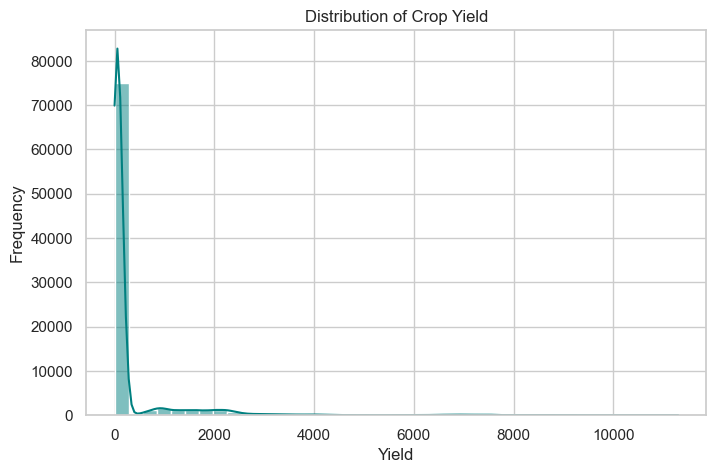

In [117]:
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['YIELD'], kde=True, bins=40, color='teal')
plt.title("Distribution of Crop Yield")
plt.xlabel("Yield")
plt.ylabel("Frequency")
plt.show()

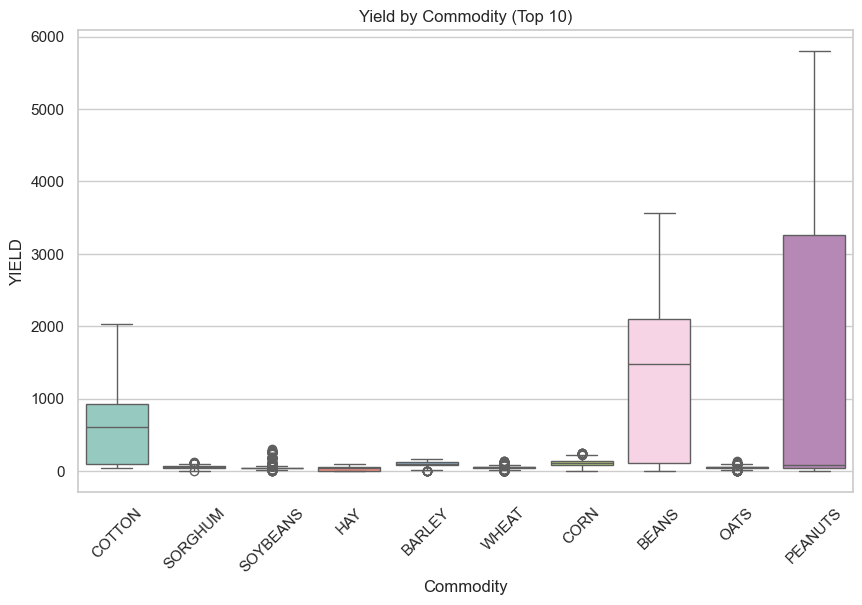

In [118]:
top_commodities = merged_df['Commodity'].value_counts().head(10).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df[merged_df['Commodity'].isin(top_commodities)],
            x='Commodity', y='YIELD', palette='Set3')
plt.title("Yield by Commodity (Top 10)")
plt.xticks(rotation=45)
plt.show()

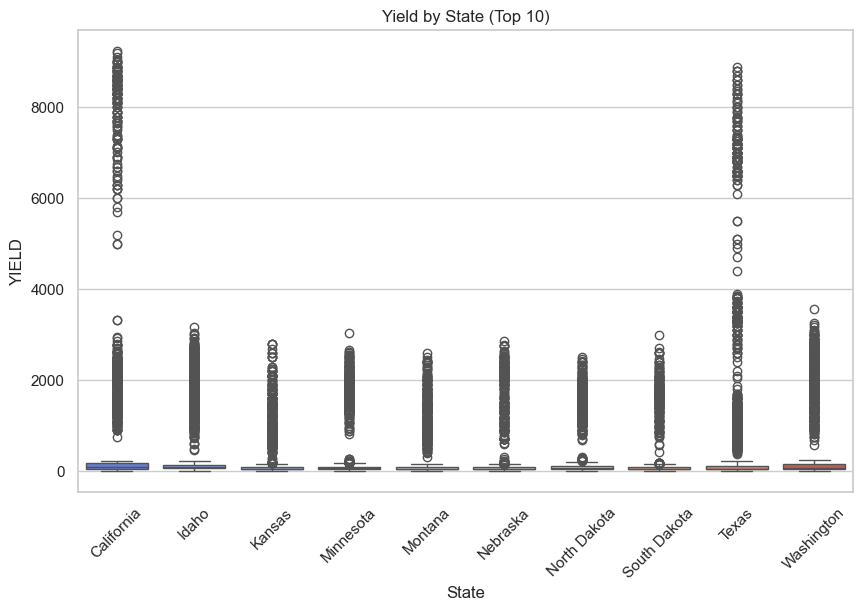

In [119]:
top_states = merged_df['State'].value_counts().head(10).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df[merged_df['State'].isin(top_states)],
            x='State', y='YIELD', palette='coolwarm')
plt.title("Yield by State (Top 10)")
plt.xticks(rotation=45)
plt.show()

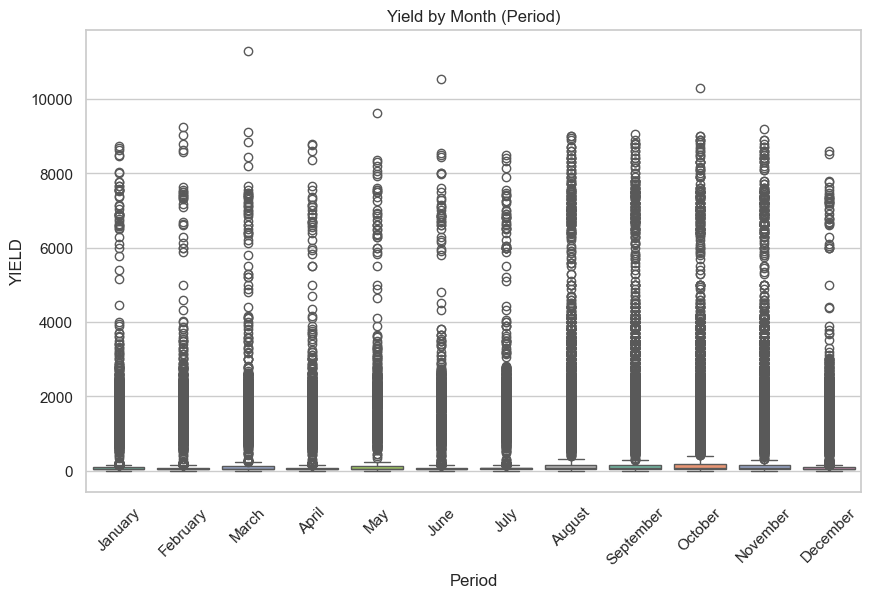

In [120]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='Period', y='YIELD', palette='Set2',
            order=['January','February','March','April','May','June',
                   'July','August','September','October','November','December'])
plt.title("Yield by Month (Period)")
plt.xticks(rotation=45)
plt.show()

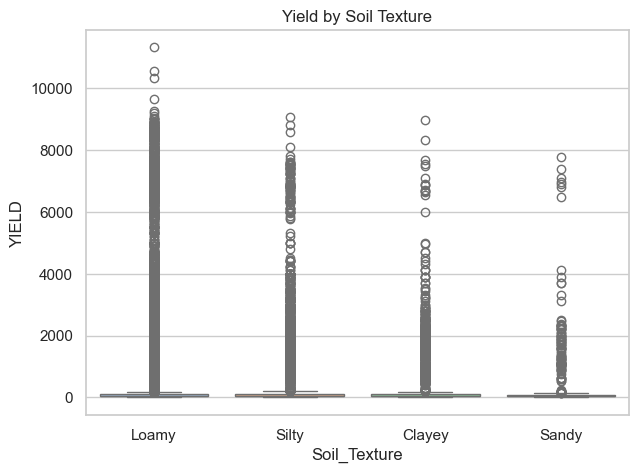

In [121]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=merged_df, x='Soil_Texture', y='YIELD', palette='pastel')
plt.title("Yield by Soil Texture")
plt.show()

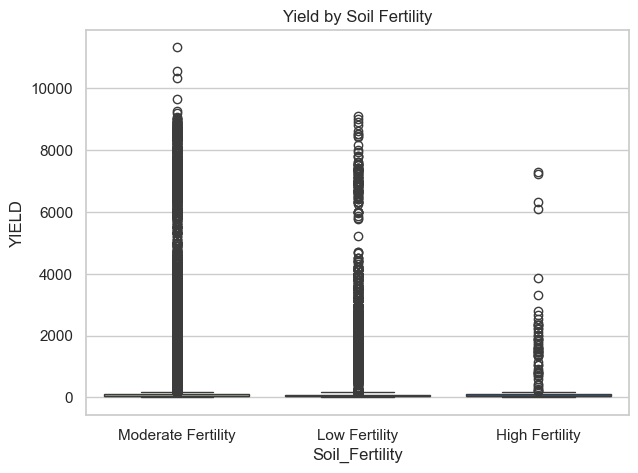

In [122]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=merged_df, x='Soil_Fertility', y='YIELD', palette='YlGnBu')
plt.title("Yield by Soil Fertility")
plt.show()

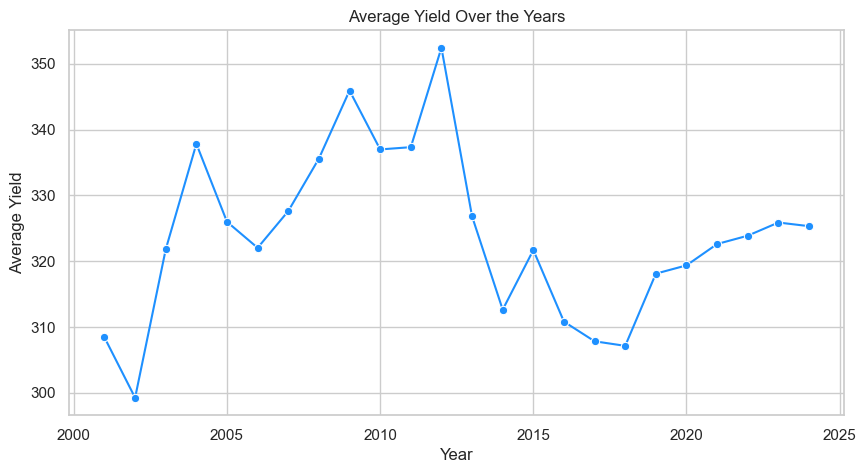

In [123]:
yearly_avg = merged_df.groupby('Year')['YIELD'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=yearly_avg, x='Year', y='YIELD', marker='o', color='dodgerblue')
plt.title("Average Yield Over the Years")
plt.ylabel("Average Yield")
plt.xlabel("Year")
plt.show()

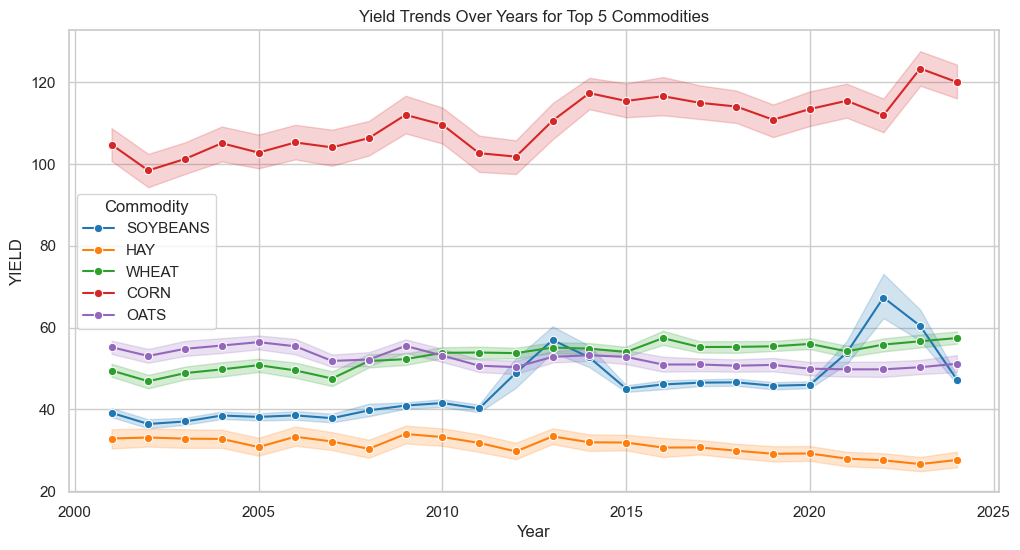

In [124]:
top5_commodities = merged_df['Commodity'].value_counts().head(5).index
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df[merged_df['Commodity'].isin(top5_commodities)],
             x='Year', y='YIELD', hue='Commodity', marker='o', palette='tab10')
plt.title("Yield Trends Over Years for Top 5 Commodities")
plt.show()

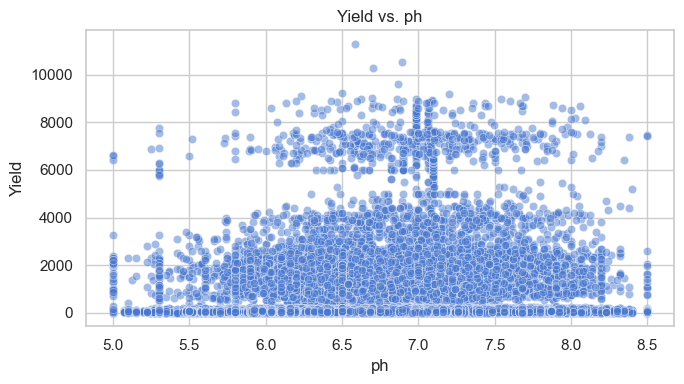

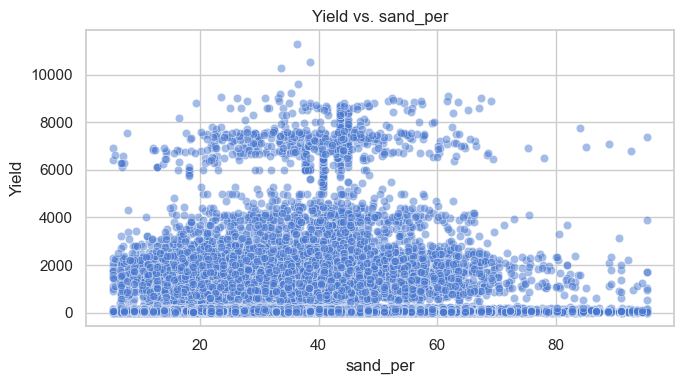

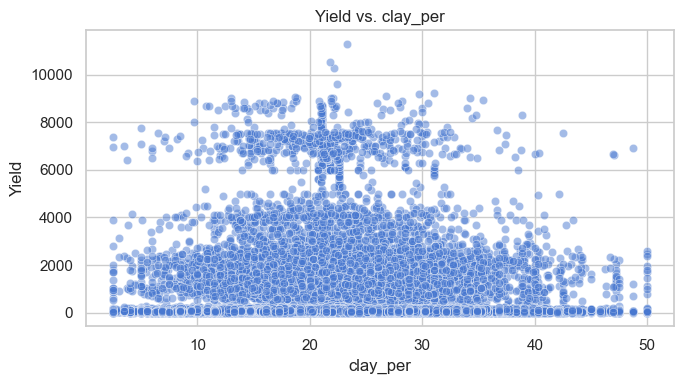

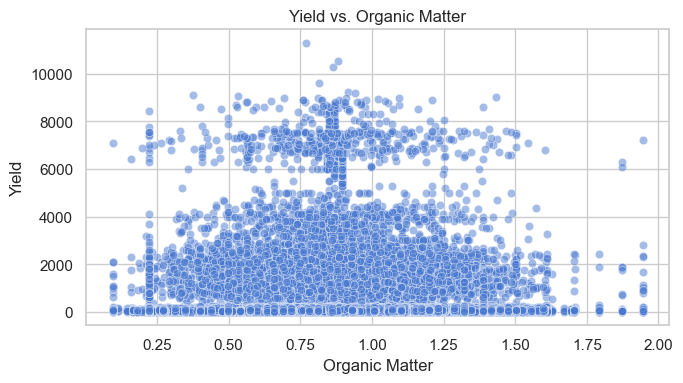

In [125]:
soil_features = ['ph', 'sand_per', 'clay_per', 'Organic Matter']
for feature in soil_features:
    plt.figure(figsize=(7, 4))
    sns.scatterplot(data=merged_df, x=feature, y='YIELD', alpha=0.5)
    plt.title(f"Yield vs. {feature}")
    plt.xlabel(feature)
    plt.ylabel("Yield")
    plt.tight_layout()
    plt.show()

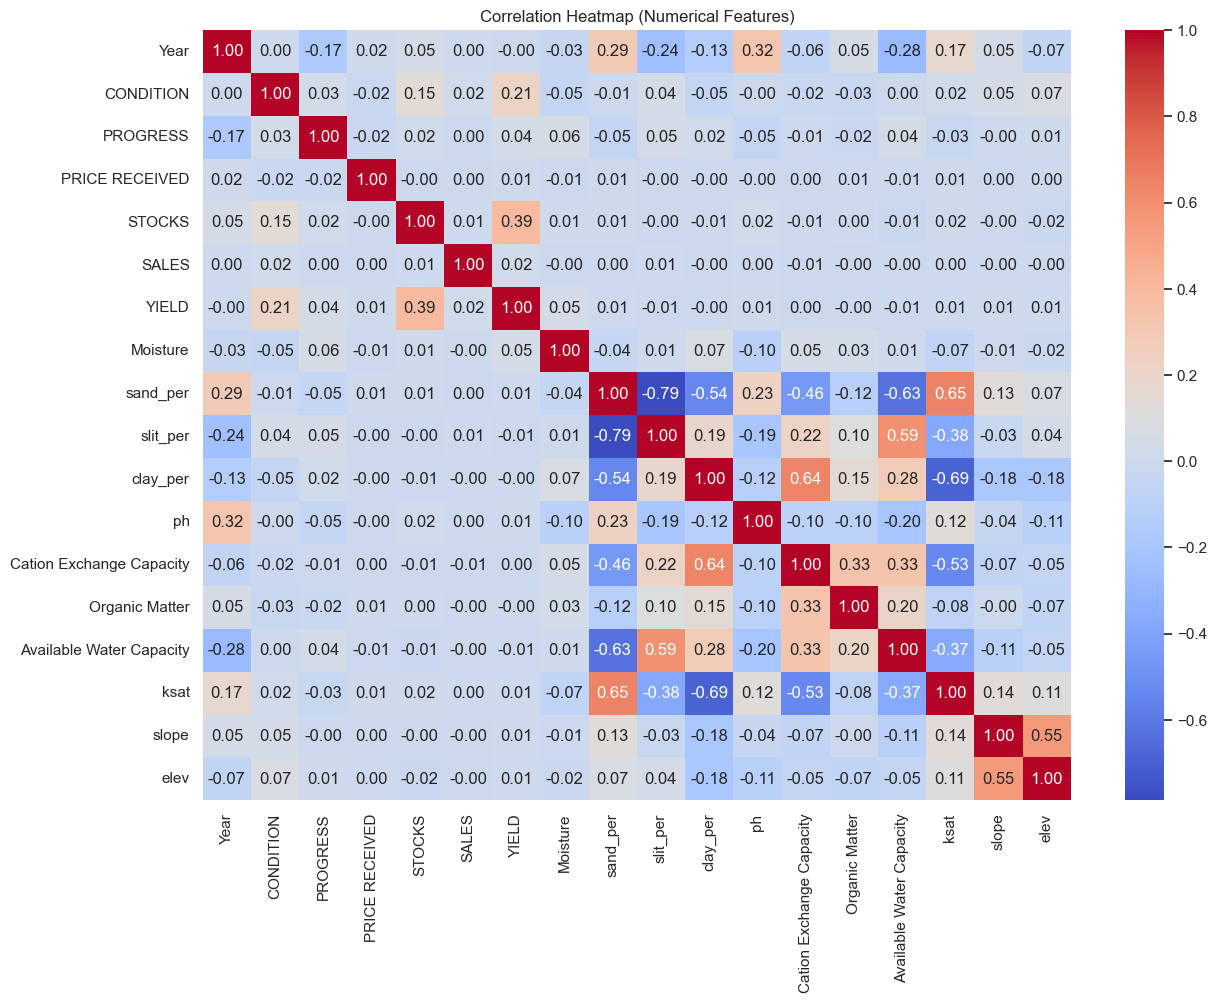

In [126]:
plt.figure(figsize=(14, 10))
sns.heatmap(merged_df.select_dtypes(include='number').corr(),
            cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()